# The Automated Data Scientist: Tools for Feature and Model Discovery
by Matthew Emery
Notebook at https://github.com/lstmemery/automl-talk/blob/master/featuretools_demo.ipynb

In [24]:
import pandas as pd
from xgboost import XGBClassifier, plot_importance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split
import featuretools as ft
from random import sample
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, RFECV, VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from category_encoders import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, confusion_matrix, matthews_corrcoef
import warnings
from itertools import chain
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from IPython.core.debugger import set_trace
from tpot import TPOTClassifier, config
from hpsklearn import HyperoptEstimator, xgboost_classification
%matplotlib inline

warnings.filterwarnings('ignore')

## Who Am I

- Background in biochemistry
- Programmed my way out of a job
- Graduate degree in Data Science from UBC
- Now work for Imbellus Inc. from Vancouver, Canada
- I build models to predict job applicant success based off of user behavior in a simulation

In [2]:
df = pd.read_csv("data/train.csv")
target = df["Survived"]
features = df.drop(columns=["Survived", "PassengerId"])
features['Pclass'] = features['Pclass'].astype('category')

(train_features, test_features, 
 train_target, test_target) = train_test_split(
    features, target, train_size=0.75, stratify=target,
    random_state=0)

train_features.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
671,1,"Davidson, Mr. Thornton",male,31.0,1,0,F.C. 12750,52.000,B71,S
417,2,"Silven, Miss. Lyyli Karoliina",female,18.0,0,2,250652,13.000,NaN,S
634,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.900,NaN,S
323,2,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1,1,248738,29.000,NaN,S
379,3,"Gustafsson, Mr. Karl Gideon",male,19.0,0,0,347069,7.775,NaN,S


In [3]:
target.mean().round(3)

0.384

## Dataset Used: Titanic
- Doing a 3:1 train/validation split, stratified
- In general, stratification is the way to go
- Set random_state to reproduce results

In [4]:
basic_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
basic_test_features = test_features.drop(columns=["Name", "Ticket", "Cabin"])

dummy_model = make_pipeline(OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked']), 
                            DummyClassifier(random_state=0))
dummy_cv = cross_val_score(dummy_model, 
                           basic_features, 
                           train_target, 
                           cv=5,
                           n_jobs=-1)
dummy_cv.mean().round(3), dummy_cv.std().round(3)

(0.552, 0.027)

## Setting a Baseline
- It's always a good idea to know where the bar is
- sklearn.dummy.DummyClassifier chooses randomly based on class distribution

In [5]:
basic_model = make_pipeline(OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked']),
                            XGBClassifier(random_state=0, n_estimators=500))
basic_cv = cross_val_score(basic_model, 
                           basic_features, 
                           train_target, 
                           cv=5,
                           n_jobs=-1)
basic_cv.mean().round(3), basic_cv.std().round(3)

(0.808, 0.022)

## No Feature Engineering
- I'm not using the sklearn implementation of OneHotEncoder
- Check out `category_encoders`
- Overall, this is a pretty good result, can we increase it?

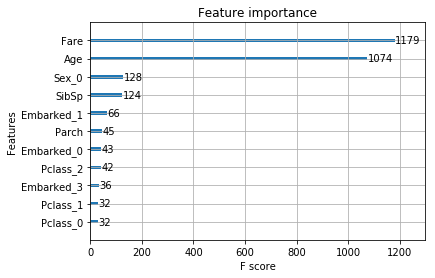

In [6]:
basic_model.fit(basic_features, train_target)
plot_importance(basic_model.named_steps['xgbclassifier'])

## Feature Importance
- Fare and Age seem important
- Be cautious, we don't know *why* they are yet
- The default implementation will underestimate the importance of categorical features
- PermutationImportance can be found in `eli5`

In [7]:
one_hot = OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked'])
one_hot_features = one_hot.fit_transform(basic_features)
column_names = one_hot_features.columns
imputer = Imputer(strategy="median")
one_hot_features = imputer.fit_transform(one_hot_features)
xgb = XGBClassifier(random_state=0, n_estimators=500)
xgb.fit(one_hot_features, train_target)
perm_imp = PermutationImportance(xgb).fit(one_hot_features, train_target)
show_weights(perm_imp, feature_names = column_names.values.tolist())

Weight,Feature
0.2249 ± 0.0203,Sex_0
0.1365 ± 0.0200,Fare
0.1362 ± 0.0295,Age
0.0680 ± 0.0129,Pclass_2
0.0243 ± 0.0048,SibSp
0.0132 ± 0.0074,Embarked_0
0.0123 ± 0.0067,Embarked_1
0.0081 ± 0.0062,Pclass_0
0.0069 ± 0.0049,Parch
0.0039 ± 0.0041,Embarked_3


In [8]:
ft_features = train_features.drop(columns=["Name", "Ticket", "Cabin"])
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=ft_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")

2018-04-25 13:31:50,607 featuretools.entityset - WARNING    index PassengerId not found in dataframe, creating new integer column


Entityset: titanic
  Entities:
    titanic (shape = [668, 8])
    classes (shape = [3, 1])
    sexes (shape = [2, 1])
    embarkeds (shape = [4, 1])
  Relationships:
    titanic.Pclass -> classes.Pclass
    titanic.Sex -> sexes.Sex
    titanic.Embarked -> embarkeds.Embarked

## Featuretools Intro
- Featuretools builds automatically generates features
- Group attributes by categories and run aggregate functions
- Requires you create an Entity Set, similar to a SQL Database

In [9]:
feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.head(5)

Built 94 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,embarkeds.MEAN(titanic.Parch),embarkeds.MEAN(titanic.Fare),embarkeds.COUNT(titanic),embarkeds.NUM_UNIQUE(titanic.Pclass),embarkeds.NUM_UNIQUE(titanic.Sex),embarkeds.MODE(titanic.Pclass) = 3.0,embarkeds.MODE(titanic.Pclass) = 1.0,embarkeds.MODE(titanic.Pclass) = unknown,embarkeds.MODE(titanic.Sex) = male,embarkeds.MODE(titanic.Sex) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
0,31.0,1,0,52.000,0,1,0,0,1,0,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
1,18.0,0,2,13.000,0,0,1,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
2,9.0,3,2,27.900,1,0,0,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
3,22.0,1,1,29.000,0,0,1,0,0,1,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0
4,19.0,0,0,7.775,1,0,0,0,1,0,...,0.37577,26.664705,487.0,3.0,2.0,1,0,0,1,0


## Deep Feature Synthesis
- Featuretools calls it's process deep feature synthesis
- These is fancy talk for nested group bys and numpy operations
- You can make your own primitives
- The encode feature operation acts like a OneHotEncoder

In [10]:
sample(features, 5), len(features)

([<Feature: classes.SKEW(titanic.Age)>,
  <Feature: embarkeds.COUNT(titanic)>,
  <Feature: classes.NUM_UNIQUE(titanic.Embarked)>,
  <Feature: embarkeds.MEAN(titanic.Fare)>,
  <Feature: sexes.MIN(titanic.Fare)>],
 109)

In [11]:
ft_cv = cross_val_score(XGBClassifier(random_state=0, n_estimators=500), 
                        feature_matrix, 
                        train_target, 
                        cv=5,
                        n_jobs=-1)
ft_cv.mean().round(3), ft_cv.std().round(3)

(0.811, 0.022)

- This is great! We've increased accuracy by 2%
- Not so fast

In [12]:
class FeaturetoolsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.features = None
        
    def fit(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        _, self.features = ft.encode_features(entity_set, features)
        return self

    def transform(self, X, y=None):
        if not self.features:
            raise ValueError("Fit the FeaturetoolsTransformer first")
        else:
            entity_set = self._create_entity(X)
            df = ft.calculate_feature_matrix(self.features, entityset=entity_set)
            return df.reindex(X.index)
        
    def fit_transform(self, X, y=None):
        entity_set = self._create_entity(X)
        entity_set, features = ft.dfs(entityset=entity_set, target_entity="id")
        df, self.features = ft.encode_features(entity_set, features)
        return df.reindex(X.index)
        
    def _create_entity(self, X):
        X = X.reset_index()
        variable_types = {variable: ft.variable_types.Categorical for variable in self.categorical_features}
        es = ft.EntitySet(id="id")
        es.entity_from_dataframe(entity_id="id",
                                 dataframe=X,
                                 index = "index",
                                 variable_types=variable_types)
        for variable in self.categorical_features:
            es.normalize_entity(base_entity_id="id",
                            new_entity_id=variable,
                            index=variable)
        return es

## Data Leakage
- Did you know you can make your own scikit-learn transformer?
- ANY interaction between your train and validation sets is data leakage!
- This includes imputation and feature engineering
- This also include cross-validation

In [13]:
ft_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", "Sex", "Embarked"]),
    XGBClassifier(random_state=0, n_estimators=500))

ft_cv = cross_val_score(ft_pipeline, 
                        ft_features, 
                        train_target, 
                        cv=5,
                        n_jobs=-1)
ft_cv.mean().round(3), ft_cv.std().round(3)

(0.805, 0.038)

- It's actually WORSE then before!
- We've added too many columns that just add noise to the data

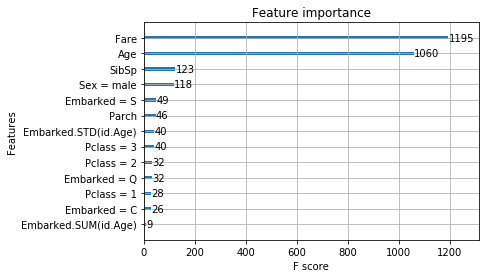

In [14]:
ft_pipeline.fit(ft_features, train_target)
plot_importance(ft_pipeline.named_steps['xgbclassifier'])

In [15]:
no_na_feature_matrix = feature_matrix.loc[:,~feature_matrix.isna().all()]

feature_matrix_columns = no_na_feature_matrix.columns.tolist()
imputed_feature_matrix = imputer.fit_transform(no_na_feature_matrix)
feature_matrix_xgb = XGBClassifier(random_state=0, n_estimators=500)
feature_matrix_xgb.fit(imputed_feature_matrix, train_target)
feature_matrix_importance = PermutationImportance(feature_matrix_xgb)
feature_matrix_importance.fit(imputed_feature_matrix, train_target)
show_weights(feature_matrix_importance, feature_names = feature_matrix_columns)

Weight,Feature
0.2210 ± 0.0274,Sex = male
0.1380 ± 0.0209,Fare
0.1302 ± 0.0104,Age
0.0746 ± 0.0103,Pclass = 3
0.0266 ± 0.0048,SibSp
0.0141 ± 0.0084,embarkeds.MODE(titanic.Pclass) = 3.0
0.0093 ± 0.0035,Embarked = S
0.0093 ± 0.0035,Parch
0.0030 ± 0.0095,Pclass = 1
0.0015 ± 0.0019,Embarked = Q


- It would seem that all we've done is add noise to our dataset
- What if we make more categories?

In [16]:
train_features['CabinClass'] = train_features["Cabin"].str.get(0)
train_features['LastName'] = train_features['Name'].str.split(", ").apply(lambda x: x[0])
train_features['Honorific'] = train_features['Name'].str.extract(" ([a-zA-z]+)")
train_features['TicketPrefix'] = train_features['Ticket'].str.extract("(.+) ")
train_features = train_features.drop(columns=["Name", "Cabin", "Ticket"])

In [17]:
es = ft.EntitySet(id="titanic")
es.entity_from_dataframe(entity_id="titanic",
                         dataframe=train_features,
                         index="PassengerId",
                         variable_types={
                             "Pclass": ft.variable_types.Categorical,
                             "Sex": ft.variable_types.Categorical,
                             "Embarked": ft.variable_types.Categorical,
                             "CabinClass": ft.variable_types.Categorical,
                             "LastName": ft.variable_types.Categorical,
                             "Honorific": ft.variable_types.Categorical,
                             "TicketPrefix": ft.variable_types.Categorical
                           })
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="classes",
                index="Pclass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="sexes",
                index="Sex")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="embarkeds",
                index="Embarked")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="cabinclasses",
                index="CabinClass")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="honorfics",
                index="Honorific")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="lastnames",
                index="LastName")
es.normalize_entity(base_entity_id="titanic",
                new_entity_id="ticketprefixes",
                index="TicketPrefix")

feature_matrix, features = ft.dfs(entityset=es,
                              target_entity="titanic",
                              save_progress="results/",
                              verbose=True)

feature_matrix, features = ft.encode_features(feature_matrix, features)

feature_matrix.sample(5)

2018-04-25 13:32:01,096 featuretools.entityset - WARNING    index PassengerId not found in dataframe, creating new integer column
Built 270 features
Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times


,Age,SibSp,Parch,Fare,Pclass = 3,Pclass = 1,Pclass = 2,Pclass = unknown,Sex = male,Sex = female,...,ticketprefixes.MODE(titanic.LastName) = Goodwin,ticketprefixes.MODE(titanic.LastName) = unknown,ticketprefixes.MODE(titanic.Honorific) = Mr,ticketprefixes.MODE(titanic.Honorific) = Miss,ticketprefixes.MODE(titanic.Honorific) = Master,ticketprefixes.MODE(titanic.Honorific) = y,ticketprefixes.MODE(titanic.Honorific) = Capt,ticketprefixes.MODE(titanic.Honorific) = Rev,ticketprefixes.MODE(titanic.Honorific) = Mrs,ticketprefixes.MODE(titanic.Honorific) = unknown
PassengerId,,,,,,,,,,,,,,,,,,,,,
256,52.0,1,1,93.500,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
596,57.0,0,0,10.500,0,0,1,0,0,1,...,0,1,1,0,0,0,0,0,0,0
584,19.0,1,1,36.750,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
213,21.0,2,0,73.500,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
486,16.0,0,0,7.775,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [18]:
fte_transformer = FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"])
transformed_extended_features = fte_transformer.fit_transform(train_features)
fte_cv = cross_val_score(XGBClassifier(random_state=0, n_estimators=500), 
                         transformed_extended_features, 
                         train_target, 
                         cv=5,
                         n_jobs=-1)
fte_cv.mean().round(3), fte_cv.std().round(3)

(0.817, 0.015)

- A slight decrease, but how bad could it be?

In [19]:
fte_pipeline = make_pipeline(FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                                             "Sex", 
                                                                             "Embarked", 
                                                                             "CabinClass",
                                                                             "LastName",
                                                                             "Honorific",
                                                                             "TicketPrefix"]),
                             XGBClassifier(random_state=0, n_estimators=500))

In [20]:
expanded_ft_cv = cross_val_score(fte_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5,
                                 n_jobs=-1)
expanded_ft_cv.mean().round(3), expanded_ft_cv.std().round(3)

(0.763, 0.054)

- This is way worse!
- What do the feature importances look like?

In [21]:
no_na_feature_matrix = feature_matrix.loc[:,~feature_matrix.isna().all()]

feature_matrix_columns = no_na_feature_matrix.columns.tolist()
imputed_feature_matrix = imputer.fit_transform(no_na_feature_matrix)
feature_matrix_xgb = XGBClassifier(random_state=0, n_estimators=500)
feature_matrix_xgb.fit(imputed_feature_matrix, train_target)
feature_matrix_importance = PermutationImportance(feature_matrix_xgb)
feature_matrix_importance.fit(imputed_feature_matrix, train_target)
show_weights(feature_matrix_importance, feature_names = feature_matrix_columns)

Weight,Feature
0.0509 ± 0.0042,Fare
0.0446 ± 0.0099,Sex = male
0.0443 ± 0.0142,lastnames.MAX(titanic.Fare)
0.0362 ± 0.0099,Age
0.0359 ± 0.0147,lastnames.SUM(titanic.Age)
0.0302 ± 0.0048,lastnames.MIN(titanic.Fare)
0.0219 ± 0.0086,Pclass = 3
0.0210 ± 0.0115,honorfics.MEAN(titanic.Fare)
0.0204 ± 0.0067,lastnames.MIN(titanic.Age)
0.0162 ± 0.0122,lastnames.SUM(titanic.Fare)


- Some of these important features don't make any sense'
- Is there anyway out of this mess?

In [30]:
class NaNDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.not_nan = None
    
    def fit(self, X, y=None):
        self.not_nan = X.isna().all()
        return self
    
    def transform(self, X, y=None):
        return X.loc[:,~self.not_nan]

In [33]:
picky_pipeline = make_pipeline(
    FeaturetoolsTransformer(categorical_features = ["Pclass", 
                                                    "Sex", 
                                                    "Embarked", 
                                                    "CabinClass",
                                                    "LastName",
                                                    "Honorific",
                                                    "TicketPrefix"]),
    Imputer(strategy='median'),
    RFECV(
        PermutationImportance(
            XGBClassifier(random_state=0, n_estimators=500), 
            cv=3), 
          cv=3, 
          step=1,
         n_jobs=-1,
         scoring='accuracy'
         ),
    XGBClassifier(random_state=0, n_estimators=500, n_jobs=-1)
)

selected_ft_cv = cross_val_score(picky_pipeline, 
                                 train_features, 
                                 train_target, 
                                 cv=5,
                                 n_jobs=-1)
selected_ft_cv.mean().round(3), selected_ft_cv.std().round(3)

KeyboardInterrupt: 

- This run didn't complete within 5 hours.
- A previous run returned a score of roughly 0.76

## Summary
- If you are going to use a package, be very careful how you use it
- Data leakage is everywhere, be very careful 